In [1]:

# Import required libraries
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Dataset path and selection parameters
dataset = "/home/lucian/University/MSc-Courses/BiometricSystems/data/"
selected_person = "007"
selected_hand = "r"
selected_spectrum = "940"

# Load matching image files
pattern = f"{selected_person}_{selected_hand}_{selected_spectrum}_*.jpg"
matching_files = glob.glob(dataset + pattern)
selected_files = glob.glob(dataset + pattern)[:3]  # Load first 6 images for demonstration


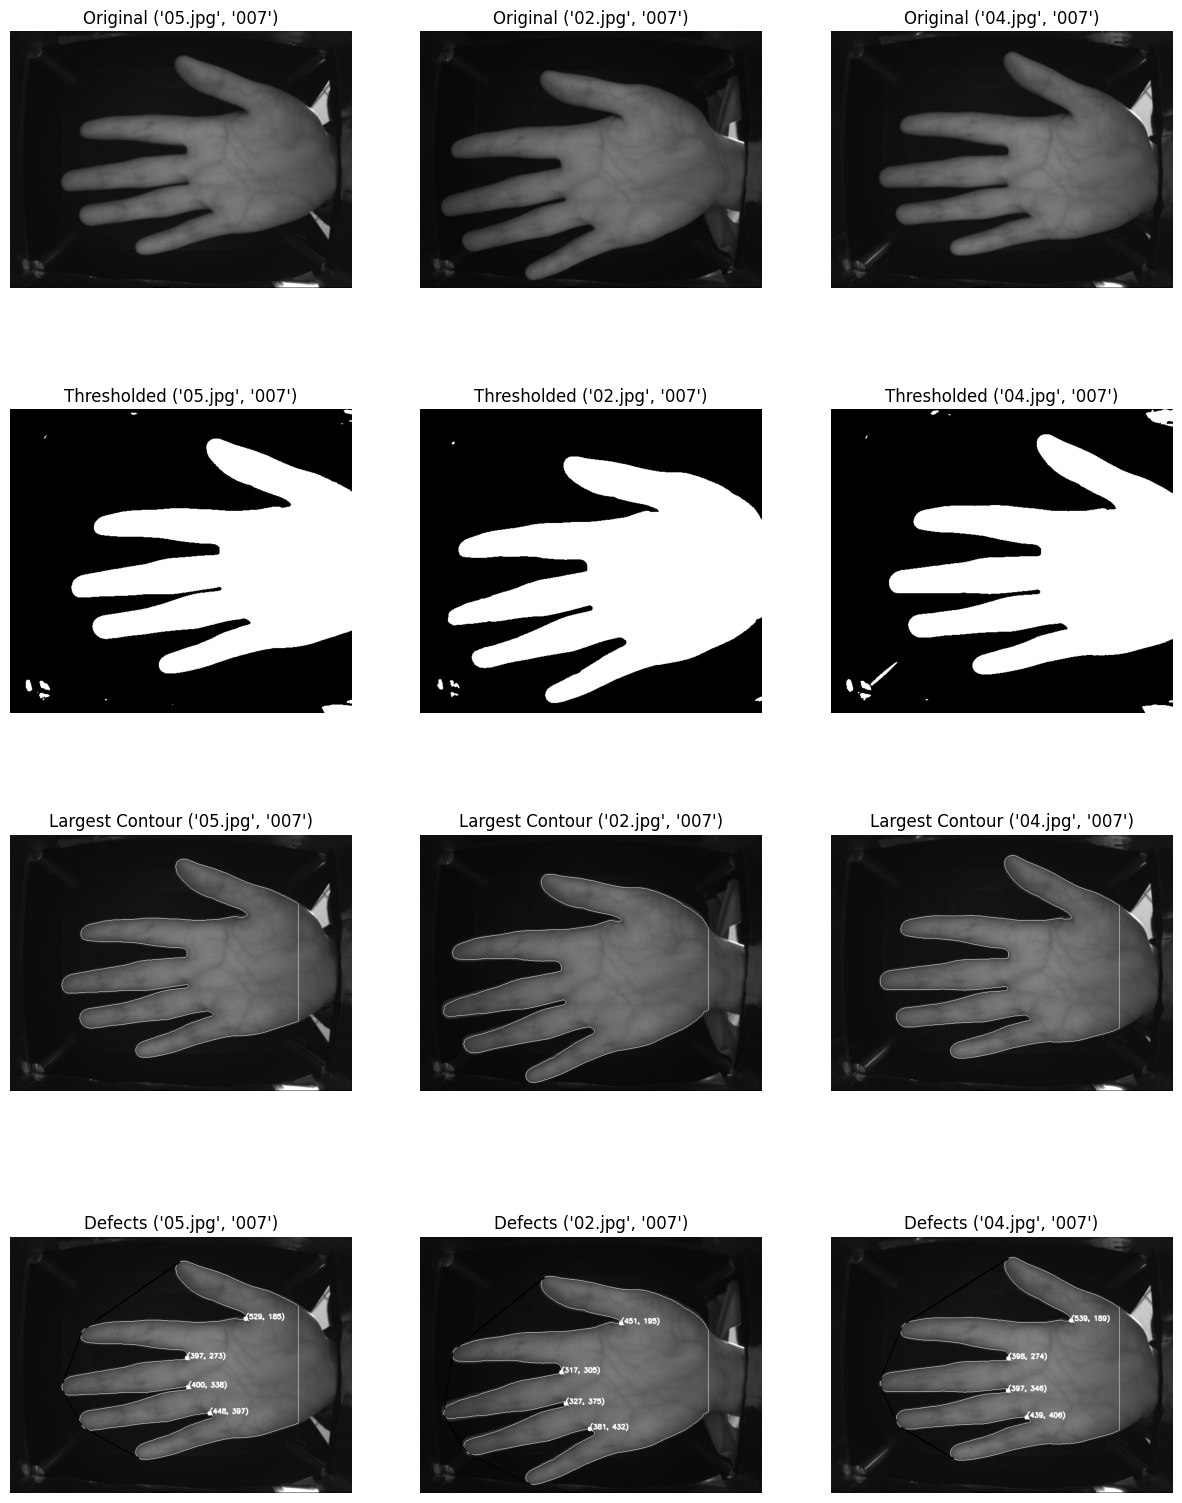

In [2]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
for idx, file_path in enumerate(selected_files):
    person_id, hand, spectrum, number = (file_path.split("/")[-1]).split("_")
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    # Work data preprocessing
    cropped_image = image[:, :image.shape[1] - 120]
    blurred = cv2.GaussianBlur(cropped_image, (5, 5), 0)
    _, thresholded = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    # Original image
    axes[0, idx].imshow(image, cmap='gray')
    axes[0, idx].set_title(f"Original {number, person_id}")
    axes[0, idx].axis('off')

    # Thresholded image
    axes[1, idx].imshow(thresholded, cmap='gray')
    axes[1, idx].set_title(f"Thresholded {number, person_id}")
    axes[1, idx].axis('off')

    # Contouring hand
    image_with_contours = np.copy(image)
    cv2.drawContours(image_with_contours, [largest_contour], -1, (255, 255, 255), 1)

    # Image with contours
    axes[2, idx].imshow(image_with_contours, cmap='gray')
    axes[2, idx].set_title(f"Largest Contour {number, person_id}")
    axes[2, idx].axis('off')

    # Calculate convexity defects
    defects_image = np.copy(image_with_contours)
    hull = cv2.convexHull(largest_contour, returnPoints=False)
    defects = cv2.convexityDefects(largest_contour, hull)

    # Sort defects based on depth
    defects = sorted(defects, key=lambda x: x[0, 3], reverse=True)

    # Draw only the first 4 defects on the defects_image
    for i in range(min(4, len(defects))):
        s, e, f, d = defects[i][0]
        start = tuple(largest_contour[s][0])
        end = tuple(largest_contour[e][0])
        far = tuple(largest_contour[f][0])
        cv2.line(defects_image, start, end, [0, 255, 0], 2)
        cv2.circle(defects_image, far, 5, [255, 255, 255], -1)

        # Add label to far points with their X and Y coordinates
        label = f"({far[0]}, {far[1]})"
        cv2.putText(defects_image, label, far, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Defects image
    axes[3, idx].imshow(defects_image, cmap='gray')
    axes[3, idx].set_title(f"Defects {number, person_id}")
    axes[3, idx].axis('off')

In [4]:
import pandas as pd

# Initialize an empty list to store features
features_list = []

for file_path in selected_files:
    person_id, hand, spectrum, number = (file_path.split("/")[-1]).split("_")
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    cropped_image = image[:, :image.shape[1] - 120]
    blurred = cv2.GaussianBlur(cropped_image, (5, 5), 0)
    _, thresholded = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate area and perimeter
    contour_area = cv2.contourArea(largest_contour)
    contour_perimeter = cv2.arcLength(largest_contour, True)

    # Calculate convex hull features
    convex_hull = cv2.convexHull(largest_contour)
    hull_area = cv2.contourArea(convex_hull)
    solidity = contour_area / hull_area if hull_area != 0 else 0

    # Calculate bounding rectangle features
    x, y, w, h = cv2.boundingRect(largest_contour)
    aspect_ratio = w / h if h != 0 else 0

    # Calculate convexity defects
    hull_indices = cv2.convexHull(largest_contour, returnPoints=False)
    defects = cv2.convexityDefects(largest_contour, hull_indices) if hull_indices is not None else None
    num_defects = len(defects) if defects is not None else 0
    avg_defect_depth = (
        sum([d[0][3] for d in defects]) / num_defects if defects is not None and num_defects > 0 else 0
    )

    # Calculate geometric moments and Hu moments
    moments = cv2.moments(largest_contour)
    hu_moments = cv2.HuMoments(moments).flatten()
    centroid_x = moments["m10"] / moments["m00"] if moments["m00"] != 0 else 0
    centroid_y = moments["m01"] / moments["m00"] if moments["m00"] != 0 else 0

    # Append the features to the list
    features_list.append({
        "Person ID": person_id,
        "Hand": hand,
        "Number": number,
        "Contour Area": contour_area,
        "Contour Perimeter": contour_perimeter,
        "Hull Area": hull_area,
        "Solidity": solidity,
        "Bounding Width": w,
        "Bounding Height": h,
        "Aspect Ratio": aspect_ratio,
        "Number of Defects": num_defects,
        "Average Defect Depth": avg_defect_depth,
        "Centroid X": centroid_x,
        "Centroid Y": centroid_y,
        **{f"Hu Moment {i+1}": hu for i, hu in enumerate(hu_moments)}
    })

# Create a DataFrame from the features
features_df = pd.DataFrame(features_list)

features_df

,Person ID,Hand,Number,Contour Area,Contour Perimeter,Hull Area,Solidity,Bounding Width,Bounding Height,Aspect Ratio,...,Average Defect Depth,Centroid X,Centroid Y,Hu Moment 1,Hu Moment 2,Hu Moment 3,Hu Moment 4,Hu Moment 5,Hu Moment 6,Hu Moment 7
0,007,r,05.jpg,126494.0,3334.552508,175115.5,0.722346,532,445,1.195506,...,8327.962963,435.352076,297.107947,0.213535,0.004514,0.000705,0.000282,7.559104e-08,0.000014,-1.001137e-07
1,007,r,02.jpg,151716.0,3448.424652,205490.5,0.738312,595,467,1.274090,...,5911.615385,398.165642,316.866558,0.205810,0.005284,0.000178,0.000261,4.307167e-08,0.000018,-3.615296e-08
2,007,r,04.jpg,130648.5,3365.682450,182799.5,0.714709,538,455,1.182418,...,7162.281250,434.146515,302.901371,0.213974,0.004019,0.000774,0.000282,6.538822e-08,0.000012,-1.144045e-07
